In [86]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.cluster import KMeans

In [87]:
# Import data
df = pd.read_csv('Data/iris.csv')
df.drop(["Id"],axis=1,inplace=True)
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


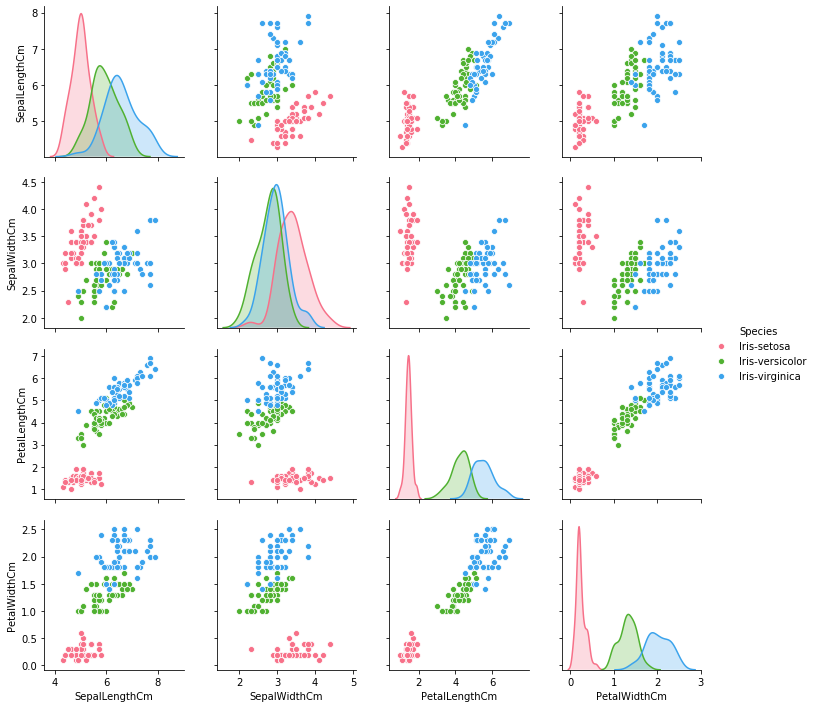

In [88]:
sns.pairplot(data=df,hue="Species",palette="husl")
plt.show()

In [89]:
# Remove Iris labels
data = df.loc[:,['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']]
data.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [90]:
# Use k-means clustering as classical unsupervised learning approach

# Use elbow rule to choose optimal k
dis = []
K = range(1,len(data)//10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
    dis.append(kmeans.inertia_)

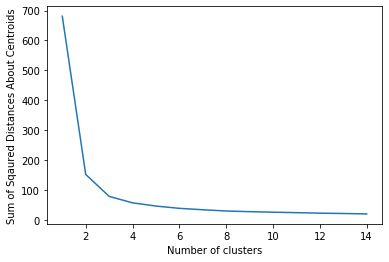

In [91]:
# Visualize Optimal k
plt.plot(K,dis)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Sqaured Distances About Centroids')
plt.show()

# Looks like 3 (maybe 2?) is most elbowy and thus the optimal k

In [92]:
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(data)

In [93]:
df['label'] = kmeans.labels_
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,label
0,5.1,3.5,1.4,0.2,Iris-setosa,0
1,4.9,3.0,1.4,0.2,Iris-setosa,0
2,4.7,3.2,1.3,0.2,Iris-setosa,0
3,4.6,3.1,1.5,0.2,Iris-setosa,0
4,5.0,3.6,1.4,0.2,Iris-setosa,0


In [94]:
df.columns[:-2]

Index(['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'], dtype='object')

/Users/Razander/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


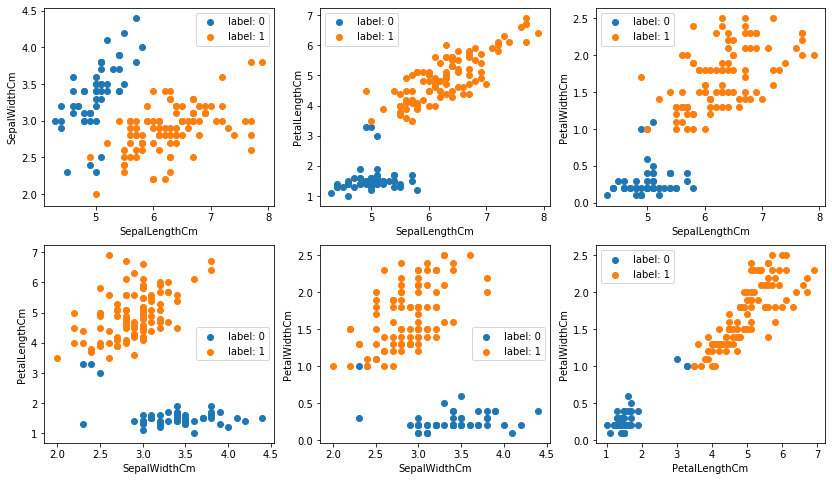

In [95]:
# Visualize data

headers = df.columns[:-2]

plt.figure(figsize=(14,8))
count = 0
for i in range(0, len(headers)):
    for j in range(i+1, len(headers)):
        count += 1
        for n in range(0, optimal_k):
            plt.subplot(2,3,count)
            plt.scatter(df[headers[i]][df['label'] == n], df[headers[j]][df['label'] == n],
                        label='label: '+str(n))
            plt.xlabel(headers[i])
            plt.ylabel(headers[j])
        plt.legend()
plt.show()

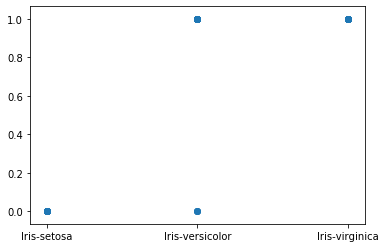

In [96]:
# Compare new labels to known labels
plt.scatter(df['Species'], df['label'])
plt.show()

In [103]:
# Count misclassifications
set_mis_label = (df[df['Species'] == 'Iris-setosa']['label'].sum()) / df[df['Species'] == 'Iris-setosa']['Species'].count()
veris_mis_label = (df[df['Species'] == 'Iris-versicolor']['label'].sum()) / df[df['Species'] == 'Iris-versicolor']['Species'].count()
virg_mis_label = (df[df['Species'] == 'Iris-virginica']['label'].sum()) / df[df['Species'] == 'Iris-virginica']['Species'].count()

print(set_mis_label,veris_mis_label,virg_mis_label)

0.0 0.94 1.0


Unsupervised learning means a lack of labels: we are looking for structure in the data, without having an *a priori* intuition what that structure might be. A great example is clustering, where the goal is to identify instances that clump together in some high-dimensional space. Unsupervised learning in general is a harder problem. Deep learning revolutionized supervised learning and it had made significant advances in unsupervised learning, but there remains plenty of room for improvement. In this notebook, we look at how we can map an unsupervised learning problem to graph optimization, which in turn we can solve on a quantum computer.

# Mapping clustering to discrete optimization

Assume that we have some points $\{x_i\}_{i=1}^N$ lying in some high-dimensional space $\mathbb{R}^d$. How do we tell which ones are close to one another and which ones are distant? To get some intuition, let's generate a simple dataset with two distinct classes. The first five instances will belong to class 1, and the second five to class 2:

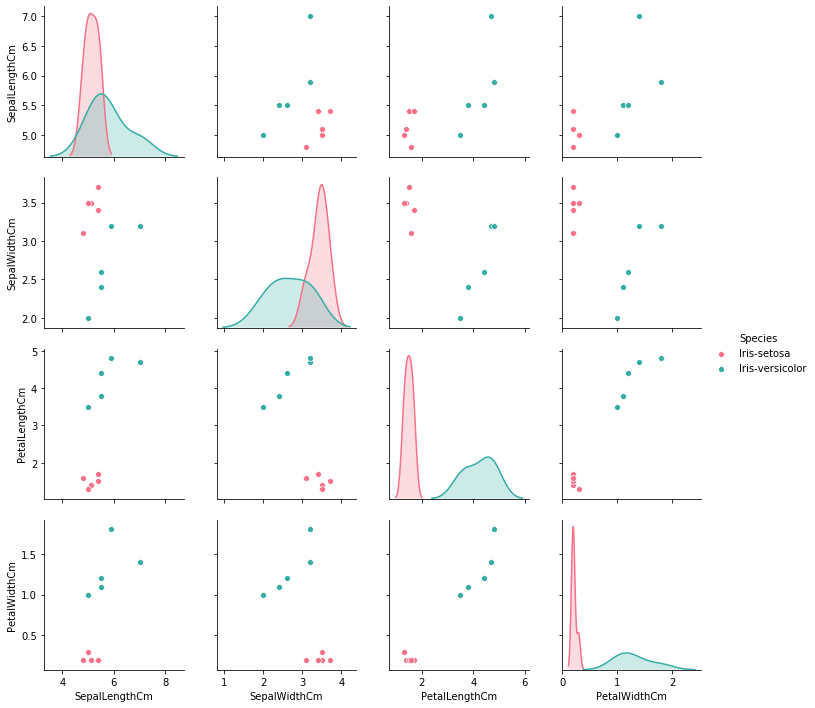

In [174]:
# Consider subset of data due to number of qubit constraints
df_sub = df.iloc[::10,:5].reset_index(drop=True)
# Constrain data to only 2 species
df_sub = df_sub.loc[(df_sub['Species'] == 'Iris-setosa') | (df_sub['Species'] == 'Iris-versicolor')]
sns.pairplot(data=df_sub,hue="Species",palette="husl")
plt.show()

In [175]:
# Remove Iris labels
data = df_sub.loc[:,['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']]
data.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,5.4,3.7,1.5,0.2
2,5.4,3.4,1.7,0.2
3,4.8,3.1,1.6,0.2
4,5.0,3.5,1.3,0.3


In [176]:
# Get number of data entries
n_instances = len(data)

# Convert dataframe into array in 4D space
data_array = data.values

The high-dimensional space is endowed with some measure of distance, the Euclidean distance being the simplest case. We can calculate all pairwise distances between the data points:

In [182]:
import itertools
w = np.zeros((n_instances, n_instances))
for i, j in itertools.product(*[range(n_instances)]*2):
    w[i, j] = np.linalg.norm(data_array[i]-data_array[j])
w.shape

(10, 10)

This matrix is sometimes called the Gram or the kernel matrix. The Gram matrix contains a fair bit of information about the topology of the points in the high-dimensional space, but it is not easy to see. We can think of the Gram matrix as the weighted adjacency matrix of a graph: two nodes represent two data instances. Their distance as contained in the Gram matrix is the weight on the edge that connects them. If the distance is zero, they are not connected by an edge. In general, this is a dense graph with many edges -- sparsity can be improved by a distance function that gets exponentially smaller.

What can we do with this graph to find the clusters? We could look for the max-cut, that is, the collection of edges that would split the graph in exactly two if removed, while maximizing the total weight of these edges [[1](#1)]. This is a well-known NP-hard problem, but it also very naturally maps to an Ising model.

The spin variables $\sigma_i \in \{-1, +1\}$ take on value $\sigma_i = +1$ if a data instance is in cluster 1 (nodes $V_1$ in the graph), and $\sigma_i = -1$ if the data instance is in cluster 2 (nodes $V_2$ in the graph). The cost of a cut is

$$
\sum_{i\in V_1, j\in V_2} w_{ij}
$$

Let us assume a fully connected graph. Then, accounting for the symmetry of the adjacency matrix, we can expand this as
$$
\frac{1}{4}\sum_{i, j} w_{ij} - \frac{1}{4} \sum_{i, j} w_{ij} \sigma_i \sigma_j
$$
$$
= \frac{1}{4}\sum_{i, j\in V} w_{ij} (1- \sigma_i \sigma_j).
$$                 

By taking the negative of this, we can directly solve the problem by a quantum optimizer.

# Solving the max-cut problem by QAOA

Most quantum computing frameworks have convenience functions defined for common graph optimization algorithms, and max-cut is a staple. This reduces our task to importing the relevant functions:

In [178]:
from qiskit.aqua import get_aer_backend, QuantumInstance
from qiskit.aqua.algorithms import QAOA
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.translators.ising import max_cut

Setting $p=1$ in the QAOA algorithm, we can initialize it with the max-cut problem.

In [186]:
qubit_operators, offset = max_cut.get_max_cut_qubitops(w)
p = 2
optimizer = COBYLA()
qaoa = QAOA(qubit_operators, optimizer, p, operator_mode='matrix')

/Users/Razander/anaconda3/lib/python3.6/site-packages/qiskit/aqua/algorithms/adaptive/vqe/vqe.py:105: DeprecationWarning: operator_mode option is deprecated and it will be removed after 0.6. Now the operator has its own mode, no need extra info to tell the VQE.
  "Now the operator has its own mode, no need extra info to tell the VQE.", DeprecationWarning)


Here the choice of the classical optimizer `COBYLA` was arbitrary. Let us run this and analyze the solution. This can take a while on a classical simulator.

In [187]:
backend = get_aer_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, shots=1)
result = qaoa.run(quantum_instance)
x = max_cut.sample_most_likely(result['eigvecs'][0])
graph_solution = max_cut.get_graph_solution(x)
print('energy:', result['energy'])
print('maxcut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

energy: 0.0
maxcut objective: -50.32774827247187
solution: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
solution objective: 0.0


Looking at the solution, the cut matches the clustering structure.

# Solving the max-cut problem by annealing

Naturally, the same problem can be solved on an annealer. Our only task is to translate the couplings and the on-site fields to match the programming interface:

In [183]:
import dimod

J, h = {}, {}
for i in range(n_instances):
    h[i] = 0
    for j in range(i+1, n_instances):
        J[(i, j)] = w[i, j]

model = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.SPIN)
sampler = dimod.SimulatedAnnealingSampler()
response = sampler.sample(model, num_reads=10)
print("Energy of samples:")
for solution in response.data():
    print("Energy:", solution.energy, "Sample:", solution.sample)

Energy of samples:
Energy: -61.23182479823889 Sample: {0: -1, 1: -1, 2: -1, 3: -1, 4: -1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1}
Energy: -61.23182479823889 Sample: {0: -1, 1: -1, 2: -1, 3: -1, 4: -1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1}
Energy: -61.23182479823889 Sample: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1}
Energy: -61.23182479823889 Sample: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1}
Energy: -61.23182479823889 Sample: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1}
Energy: -61.23182479823889 Sample: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1}
Energy: -61.23182479823889 Sample: {0: -1, 1: -1, 2: -1, 3: -1, 4: -1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1}
Energy: -61.23182479823889 Sample: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1}
Energy: -61.23182479823889 Sample: {0: -1, 1: -1, 2: -1, 3: -1, 4: -1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1}
Energy: -61.23182479823889 Sample: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: -1,

In [184]:
labels = pd.DataFrame(data=solution.sample,index=[0]).T
labels = labels.rename(columns={0:'label'})
print('unique labels:',labels['label'].unique())

df_sub['label'] = labels
df_sub.head()

unique labels: [ 1 -1]


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,label
0,5.1,3.5,1.4,0.2,Iris-setosa,1
1,5.4,3.7,1.5,0.2,Iris-setosa,1
2,5.4,3.4,1.7,0.2,Iris-setosa,1
3,4.8,3.1,1.6,0.2,Iris-setosa,1
4,5.0,3.5,1.3,0.3,Iris-setosa,1


/Users/Razander/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


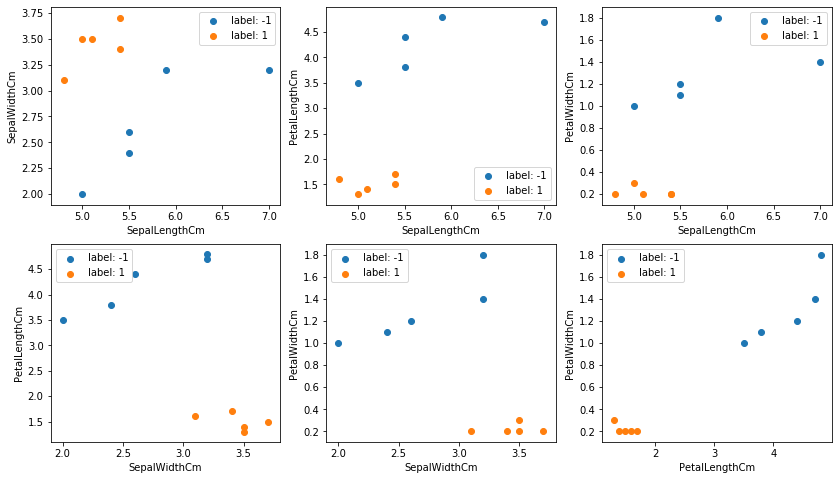

In [185]:
# Visualize data
optimal_k = 2
headers = df_sub.columns[:-2]

plt.figure(figsize=(14,8))
count = 0
for i in range(0, len(headers)):
    for j in range(i+1, len(headers)):
        count += 1
        for n in range(-1, 2, 2):
            plt.subplot(2,3,count)
            plt.scatter(df_sub[headers[i]][df_sub['label'] == n], df_sub[headers[j]][df_sub['label'] == n],
                        label='label: '+str(n))
            plt.xlabel(headers[i])
            plt.ylabel(headers[j])
        plt.legend()
plt.show()

If you look at the first sample, you will see that the first five data instances belong to the same graph partition, matching the actual cluster.

# References

[1] Otterbach, J. S., Manenti, R., Alidoust, N., Bestwick, A., Block, M., Bloom, B., Caldwell, S., Didier, N., Fried, E. Schuyler, Hong, S., Karalekas, P., Osborn, C. B., Papageorge, A., Peterson, E. C., Prawiroatmodjo, G., Rubin, N., Ryan, Colm A., Scarabelli, D., Scheer, M., Sete, E. A., Sivarajah, P., Smith, Robert S., Staley, A., Tezak, N., Zeng, W. J., Hudson, A., Johnson, Blake R., Reagor, M., Silva, M. P. da, Rigetti, C. (2017). [Unsupervised Machine Learning on a Hybrid Quantum Computer](https://arxiv.org/abs/1712.05771). *arXiv:1712.05771*. <a id='1'></a>